In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import re
import string
import time

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.pipeline import Pipeline

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer


In [4]:
# Descargar recursos necesarios de NLTK
nltk.download('stopwords')
nltk.download('punkt')

# Configuración para visualizaciones
plt.style.use('ggplot')
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

# Configurar para español
spanish_stemmer = SnowballStemmer('spanish')
try:
    spanish_stopwords = set(stopwords.words('spanish'))
except:
    # Si no se pueden cargar las stopwords en español, descargarlas
    nltk.download('stopwords')
    spanish_stopwords = set(stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
# Función para preprocesar texto en español
def preprocess_spanish_text(text):
    if isinstance(text, str):
        # Convertir a minúsculas
        text = text.lower()

        # Eliminar URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

        # Eliminar etiquetas HTML
        text = re.sub(r'<.*?>', '', text)

        # Eliminar caracteres especiales y dígitos
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\d+', '', text)

        # Eliminar espacios múltiples
        text = re.sub(r'\s+', ' ', text).strip()

        # Tokenizar y eliminar stopwords
        tokens = nltk.word_tokenize(text)
        tokens = [word for word in tokens if word not in spanish_stopwords]

        # Aplicar stemming (reducción a raíz)
        stemmed_tokens = [spanish_stemmer.stem(word) for word in tokens]

        return ' '.join(stemmed_tokens)
    return ""

In [6]:
# Función para mostrar avance
def show_progress(message):
    for i in range(3):
        print(f"{message}{'.' * (i+1)}", end='\r')
        time.sleep(0.3)
    print(f"{message}... Completado!")

In [9]:
# Cargar dataset
print("PASO 1: Cargando el dataset")
combined_clean_path = "/content/fake_news_combined_clean.csv"
try:
    df = pd.read_csv(combined_clean_path)
    print(f"Dataset cargado exitosamente con {df.shape[0]} registros y {df.shape[1]} columnas.")
except Exception as e:
    print(f"Error al cargar el dataset: {e}")
    print("Por favor, asegúrate de que el archivo 'fake_news_combined_clean.csv' está en la carpeta /content/")
    raise

PASO 1: Cargando el dataset
Dataset cargado exitosamente con 4349 registros y 6 columnas.



PASO 2: Explorando el dataset

Primeras 5 filas del dataset:


,label,content,title,source,split,dataset
0,Falsa,"RAE INCLUIRÁ LA PALABRA ""LADY"" EN EL DICCIONAR...","RAE INCLUIRÁ LA PALABRA ""LADY"" EN EL DICCIONAR...",El Ruinaversal,train,posadas
1,Falsa,"La palabra ""haiga"", aceptada por la RAE La Rea...","La palabra ""haiga"", aceptada por la RAE",Hay noticia,train,posadas
2,Falsa,YORDI ROSADO ESCRIBIRÁ Y DISEÑARÁ LOS NUEVOS L...,YORDI ROSADO ESCRIBIRÁ Y DISEÑARÁ LOS NUEVOS L...,El Ruinaversal,train,posadas
3,Verdadera,UNAM capacitará a maestros para aprobar prueba...,UNAM capacitará a maestros para aprobar prueba...,EL UNIVERSAL,train,posadas
4,Falsa,Alerta: pretenden aprobar libros escolares con...,pretenden aprobar libros escolares con conteni...,Lamula,train,posadas



Distribución de clases:


,count
label,
Verdadera,2847
Falsa,1502


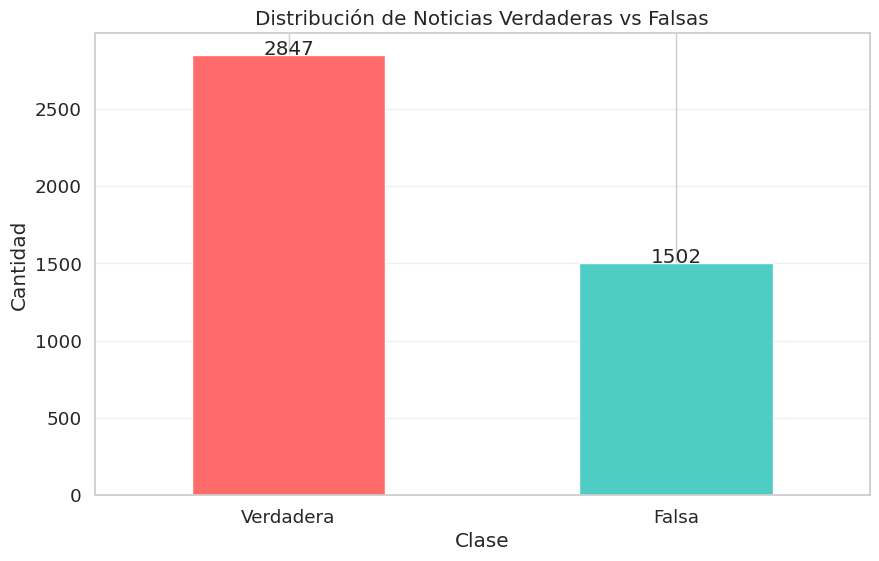

In [10]:
# Mostrar información básica del dataset
print("\nPASO 2: Explorando el dataset")
print("\nPrimeras 5 filas del dataset:")
display(df.head())

print("\nDistribución de clases:")
class_dist = df['label'].value_counts()
display(class_dist)

# Visualizar distribución de clases
plt.figure(figsize=(10, 6))
class_dist.plot(kind='bar', color=['#FF6B6B', '#4ECDC4'])
plt.title('Distribución de Noticias Verdaderas vs Falsas')
plt.xlabel('Clase')
plt.ylabel('Cantidad')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
for i, v in enumerate(class_dist):
    plt.text(i, v + 0.5, str(v), ha='center')
plt.show()

In [14]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [15]:
# Preprocesamiento de datos
print("\nPASO 3: Preprocesando los datos específicamente para español")
show_progress("Limpiando y normalizando texto español")

# Aplicar preprocesamiento específico para español a columnas de texto
df['clean_content'] = df['content'].apply(preprocess_spanish_text)
df['clean_title'] = df['title'].apply(preprocess_spanish_text)

# Mostrar ejemplo de texto preprocesado
example_idx = 0
print("\nEjemplo de preprocesamiento para español:")
print(f"Original: {df.iloc[example_idx]['title']}")
print(f"Preprocesado: {df.iloc[example_idx]['clean_title']}")

# Combinar título y contenido con pesos diferentes
# Damos más peso al título porque suele ser más indicativo para fake news
df['text_features'] = df['clean_title'] + " " + df['clean_title'] + " " + df['clean_content']

# Convertir etiquetas a formato numérico
if df['label'].dtype == 'object':
    label_map = {'Falsa': 0, 'falsa': 0, 'FALSA': 0, 'fake': 0, 'Fake': 0, 'FALSE': 0, 'False': 0,
                'Verdadera': 1, 'verdadera': 1, 'VERDADERA': 1, 'real': 1, 'Real': 1, 'true': 1, 'True': 1, 'TRUE': 1}
    df['label_num'] = df['label'].map(label_map)

    # Verificar si hay etiquetas que no se mapearon
    unmapped = df[df['label_num'].isna()]
    if not unmapped.empty:
        print(f"Advertencia: {len(unmapped)} etiquetas no mapeadas.")

        # Si hay valores no mapeados, inferir mapeo automáticamente
        unique_labels = df['label'].unique()
        print(f"Etiquetas únicas encontradas: {unique_labels}")

        if len(unique_labels) == 2:
            df['label_num'] = df['label'].map({unique_labels[0]: 0, unique_labels[1]: 1})
            print(f"Mapeo automático: {unique_labels[0]} → 0, {unique_labels[1]} → 1")
        else:
            # Crear mapeo para todas las clases únicas
            for i, label in enumerate(unique_labels):
                if label not in label_map:
                    label_map[label] = i % 2  # Alternar entre 0 y 1
            df['label_num'] = df['label'].map(label_map)
            print("Mapeo realizado para todas las clases:")
            for label, value in label_map.items():
                if label in unique_labels:
                    print(f"  {label} → {value}")
else:
    # Si ya es numérica, asegurarse de que sea binaria (0 o 1)
    df['label_num'] = df['label']

# Eliminar filas con valores NaN en las características o etiquetas
df_clean = df.dropna(subset=['text_features', 'label_num'])
print(f"\nPreprocesamiento completado. Quedan {df_clean.shape[0]} registros válidos.")


PASO 3: Preprocesando los datos específicamente para español
Limpiando y normalizando texto español... Completado!

Ejemplo de preprocesamiento para español:
Original: RAE INCLUIRÁ LA PALABRA "LADY" EN EL DICCIONARIO DEL IDIOMA ESPAÑOL COMO DEFINICIÓN DE "MUJER PROBLEMÁTICA"
Preprocesado: rae inclu palabr lady diccionari idiom español definicion muj problemat

Preprocesamiento completado. Quedan 4349 registros válidos.


In [16]:
# Dividir los datos en conjuntos de entrenamiento y prueba
print("\nPASO 4: Dividiendo los datos para entrenamiento y prueba")
X_train, X_test, y_train, y_test = train_test_split(
    df_clean['text_features'],
    df_clean['label_num'],
    test_size=0.2,
    random_state=42,
    stratify=df_clean['label_num']
)

print(f"División completada:")
print(f"  • Conjunto de entrenamiento: {X_train.shape[0]} muestras ({X_train.shape[0]/df_clean.shape[0]:.1%})")
print(f"  • Conjunto de prueba: {X_test.shape[0]} muestras ({X_test.shape[0]/df_clean.shape[0]:.1%})")

# Configurar vectorizador específico para español
# Usamos un rango de n-gramas de 1 a 3 para capturar frases más largas
# que son comunes en español y podrían ser indicativas de fake news
spanish_vectorizer = TfidfVectorizer(
    max_features=15000,
    ngram_range=(1, 3),
    min_df=5,
    max_df=0.8,
    sublinear_tf=True
)


PASO 4: Dividiendo los datos para entrenamiento y prueba
✅ División completada:
  • Conjunto de entrenamiento: 3479 muestras (80.0%)
  • Conjunto de prueba: 870 muestras (20.0%)


In [17]:
# Entrenar diferentes modelos adaptados para español
print("\nPASO 5: Entrenando varios modelos de clasificación adaptados para español")

models = {
    'Regresión Logística': Pipeline([
        ('tfidf', spanish_vectorizer),
        ('classifier', LogisticRegression(max_iter=1000, C=1.0, class_weight='balanced'))
    ]),
    'Naive Bayes': Pipeline([
        ('tfidf', spanish_vectorizer),
        ('classifier', MultinomialNB(alpha=0.1))
    ]),
    'Random Forest': Pipeline([
        ('tfidf', spanish_vectorizer),
        ('classifier', RandomForestClassifier(n_estimators=100, max_depth=None,
                                            min_samples_split=10, random_state=42))
    ])
}

results = {}
model_reports = {}
model_matrices = {}
model_roc = {}

# Entrenar y evaluar cada modelo
for name, model in models.items():
    print(f"\nEntrenando modelo: {name}")
    show_progress(f"Entrenando {name}")

    # Entrenar modelo
    model.fit(X_train, y_train)

    # Evaluar en conjunto de prueba
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # Probabilidad de la clase positiva

    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    model_reports[name] = classification_report(y_test, y_pred, output_dict=True)
    model_matrices[name] = confusion_matrix(y_test, y_pred)

    # Datos para curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    model_roc[name] = (fpr, tpr, roc_auc)

    print(f"✅ {name}: Precisión = {accuracy:.4f}, AUC = {roc_auc:.4f}")

    # Mostrar informe detallado
    print("\nInforme de clasificación:")
    print(classification_report(y_test, y_pred))



PASO 5: Entrenando varios modelos de clasificación adaptados para español

Entrenando modelo: Regresión Logística
Entrenando Regresión Logística... Completado!
✅ Regresión Logística: Precisión = 0.8207, AUC = 0.8793

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.69      0.87      0.77       300
           1       0.92      0.79      0.85       570

    accuracy                           0.82       870
   macro avg       0.81      0.83      0.81       870
weighted avg       0.84      0.82      0.82       870


Entrenando modelo: Naive Bayes
Entrenando Naive Bayes... Completado!
✅ Naive Bayes: Precisión = 0.7368, AUC = 0.8156

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.66      0.48      0.56       300
           1       0.76      0.87      0.81       570

    accuracy                           0.74       870
   macro avg       0.71      0.68      0.68       870
weighted avg


PASO 6: Evaluando y comparando modelos


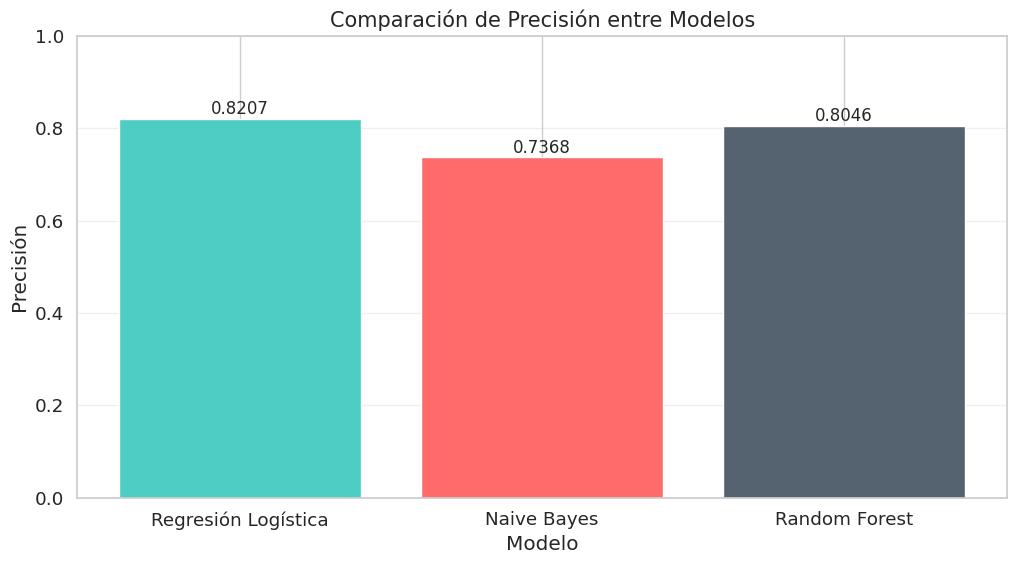

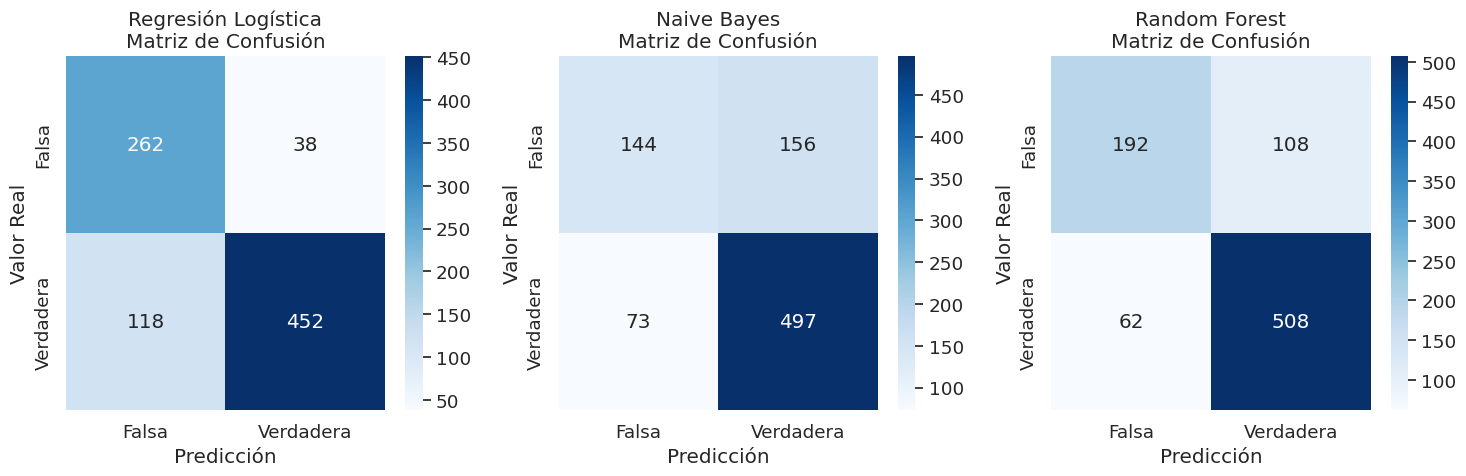

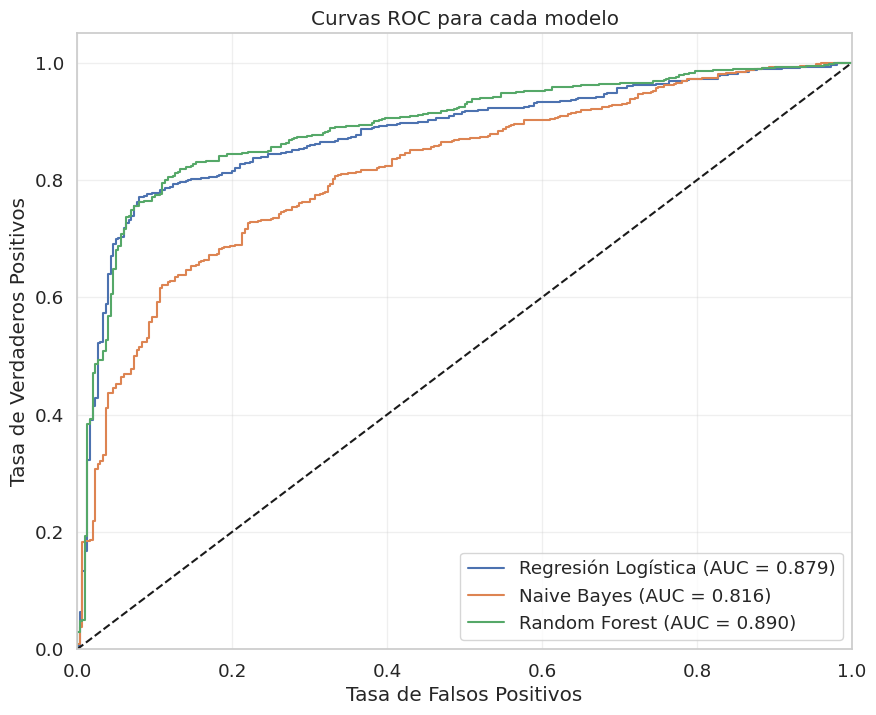


🏆 El mejor modelo es: Regresión Logística con una precisión de 0.8207


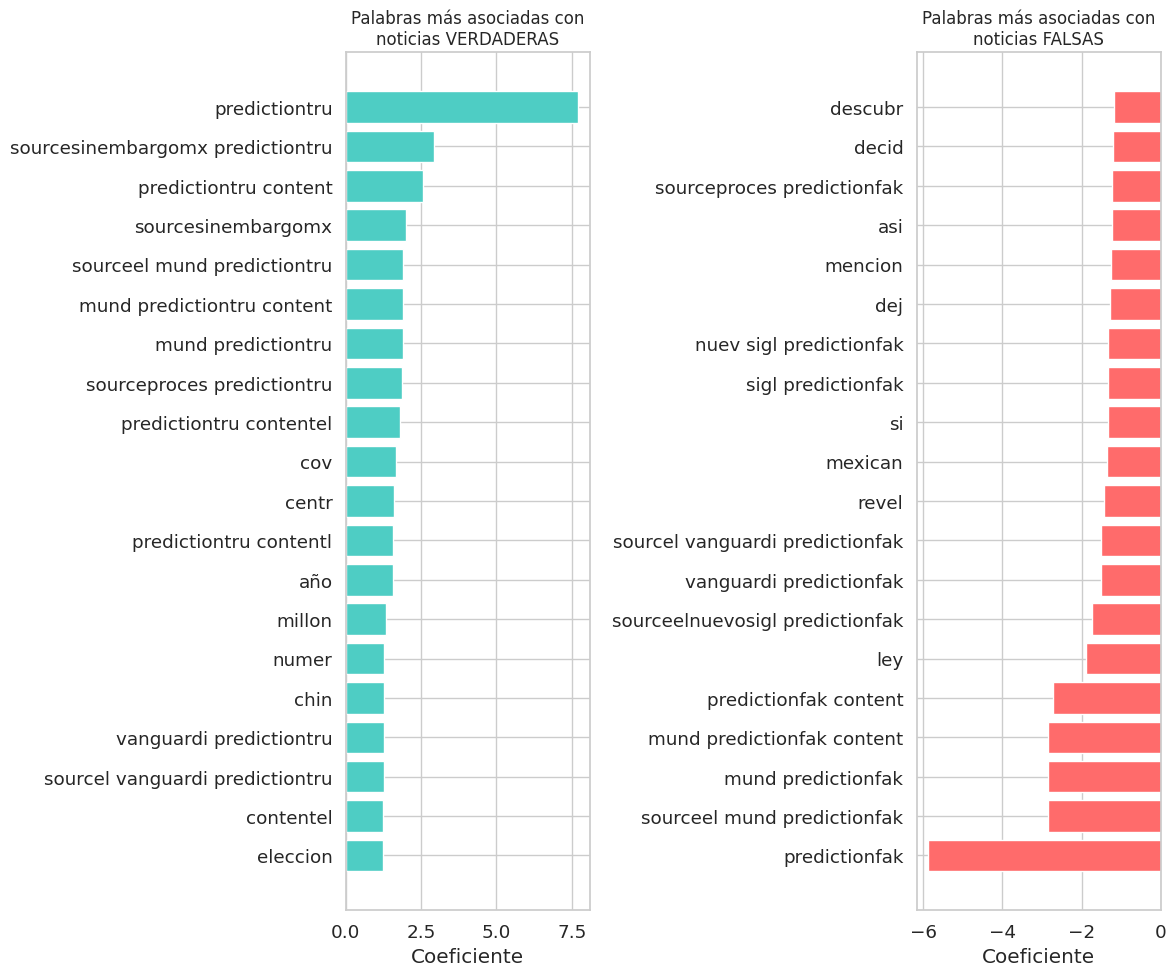

In [18]:
# Visualizaciones de resultados
print("\nPASO 6: Evaluando y comparando modelos")

# Comparar rendimiento de modelos
plt.figure(figsize=(12, 6))
bars = plt.bar(results.keys(), results.values(), color=['#4ECDC4', '#FF6B6B', '#556270'])
plt.title('Comparación de Precisión entre Modelos', fontsize=15)
plt.xlabel('Modelo')
plt.ylabel('Precisión')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)

# Añadir etiquetas a las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.4f}', ha='center', fontsize=12)
plt.show()

# Mostrar matrices de confusión para cada modelo
fig, axes = plt.subplots(1, len(models), figsize=(15, 5))
for i, (name, cm) in enumerate(model_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'{name}\nMatriz de Confusión')
    axes[i].set_xlabel('Predicción')
    axes[i].set_ylabel('Valor Real')
    axes[i].set_xticklabels(['Falsa', 'Verdadera'])
    axes[i].set_yticklabels(['Falsa', 'Verdadera'])
plt.tight_layout()
plt.show()

# Curvas ROC
plt.figure(figsize=(10, 8))
for name, (fpr, tpr, roc_auc) in model_roc.items():
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC para cada modelo')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# Seleccionar el mejor modelo
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
print(f"\n🏆 El mejor modelo es: {best_model_name} con una precisión de {results[best_model_name]:.4f}")

# Extraer vectorizador y clasificador del pipeline
vectorizer = best_model.named_steps['tfidf']
classifier = best_model.named_steps['classifier']

# Mostrar las palabras más importantes para cada clase
if hasattr(classifier, 'coef_'):  # Para Regresión Logística
    feature_names = vectorizer.get_feature_names_out()

    # Obtener coeficientes
    coefs = classifier.coef_[0]
    top_positive_coefs = np.argsort(coefs)[-20:]
    top_negative_coefs = np.argsort(coefs)[:20]

    # Visualizar palabras más importantes
    plt.figure(figsize=(12, 10))

    # Palabras asociadas con noticias verdaderas
    plt.subplot(1, 2, 1)
    plt.barh([feature_names[i] for i in top_positive_coefs],
            [coefs[i] for i in top_positive_coefs],
            color='#4ECDC4')
    plt.title('Palabras más asociadas con\nnoticias VERDADERAS', fontsize=12)
    plt.xlabel('Coeficiente')

    # Palabras asociadas con noticias falsas
    plt.subplot(1, 2, 2)
    plt.barh([feature_names[i] for i in top_negative_coefs],
            [coefs[i] for i in top_negative_coefs],
            color='#FF6B6B')
    plt.title('Palabras más asociadas con\nnoticias FALSAS', fontsize=12)
    plt.xlabel('Coeficiente')

    plt.tight_layout()
    plt.show()